In [54]:
import pandas as pd
from darts import TimeSeries
from darts.models import NHiTSModel
import torch
from darts.utils.likelihood_models import GaussianLikelihood
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.dataprocessing.transformers import Scaler
from darts.metrics import rmse
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import os
import pickle

import warnings

warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [55]:
# Define the columns to include in the new DataFrame
order_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'Order Management CPU Usage',
    'Order Management Memory Usage',
    'Order Management Request Count',
    'Order Management 5xx Failures',
    'Order Management Pod Count'
]
product_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'Product Catalog CPU Usage',
    'Product Catalog Memory Usage',
    'Product Catalog Request Count',
    'Product Catalog 5xx Failures',
    'Product Catalog Pod Count'
]
shipping_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'Shipping Logistics CPU Usage',
    'Shipping Logistics Memory Usage',
    'Shipping and Logistics Request Count',
    'Shipping and Logistics 5xx Failures',
    'Shipping Logistics Pod Count'
]
user_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'User Account CPU Usage',
    'User Account Memory Usage',
    'User Account Request Count',
    'User Account 5xx Failures',
    'User Account Pod Count'
]
reviews_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'Review Rating CPU Usage',
    'Review Rating Memory Usage',
    'Review and Rating Request Count',
    'Review and Rating 5xx Failures',
    'Review Rating Pod Count'
]
payment_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'Payment Processing CPU Usage',
    'Payment Processing Memory Usage',
    'Payment Processing Request Count',
    'Payment Processing 5xx Failures',
    'Payment Processing Pod Count'
]

file_path = '~/Downloads/Collected Data - 24 Sep 23:59:00.csv'

# Creating dataframes for each service
order_df = pd.read_csv(file_path, usecols=order_columns_to_include)
product_df = pd.read_csv(file_path, usecols=product_columns_to_include)
user_df = pd.read_csv(file_path, usecols=user_columns_to_include)
reviews_df = pd.read_csv(file_path, usecols=reviews_columns_to_include)
shipping_df = pd.read_csv(file_path, usecols=shipping_columns_to_include)
payment_df = pd.read_csv(file_path, usecols=payment_columns_to_include)

order_df.fillna(0, inplace=True)
product_df.fillna(0, inplace=True)
user_df.fillna(0, inplace=True)
reviews_df.fillna(0, inplace=True)
shipping_df.fillna(0, inplace=True)
payment_df.fillna(0, inplace=True)

product_df.head()

,Time,Cluster CPU,Cluster Memory,Product Catalog CPU Usage,Product Catalog Memory Usage,Product Catalog Pod Count,Product Catalog Request Count,Product Catalog 5xx Failures
0,2024-08-21 00:00:00,18.7,26.8,48.4,16.9,3,7430.0,0.0
1,2024-08-21 00:01:00,19.8,27.0,39.0,16.9,3,8558.0,0.0
2,2024-08-21 00:02:00,20.8,27.0,53.8,16.9,3,8686.0,0.0
3,2024-08-21 00:03:00,20.7,27.0,35.1,16.9,3,7732.0,0.0
4,2024-08-21 00:04:00,20.3,27.0,42.6,16.9,3,7058.0,0.0


In [56]:
# Convert 'Timestamp [ms]' to datetime and set it as the index
order_df['Time'] = pd.to_datetime(order_df['Time'])
order_df.set_index('Time', inplace=True)

# Specify the frequency of your time series (e.g., 'H' for hourly, 'D' for daily)
frequency = 'm'  # Replace 'your_frequency' with the appropriate frequency code

# Preserve the 'Timestamp [ms]' column
order_df['Time'] = order_df.index

order_df.head()

,Cluster CPU,Cluster Memory,Order Management CPU Usage,Order Management Memory Usage,Order Management Pod Count,Order Management Request Count,Order Management 5xx Failures,Time
Time,,,,,,,,
2024-08-21 00:00:00,18.7,26.8,83.7,51.7,4,7320.0,0.0,2024-08-21 00:00:00
2024-08-21 00:01:00,19.8,27.0,95.4,51.6,4,8318.0,2.0,2024-08-21 00:01:00
2024-08-21 00:02:00,20.8,27.0,87.5,51.7,4,8660.0,0.0,2024-08-21 00:02:00
2024-08-21 00:03:00,20.7,27.0,86.5,51.8,4,7706.0,0.0,2024-08-21 00:03:00
2024-08-21 00:04:00,20.3,27.0,83.8,51.7,4,7354.0,0.0,2024-08-21 00:04:00


In [57]:
# Create TimeSeries objects for each feature
series_cluster_cpu = TimeSeries.from_dataframe(order_df, 'Time', 'Cluster CPU')
series_cluster_memory = TimeSeries.from_dataframe(order_df, 'Time', 'Cluster Memory')
series_order_cpu = TimeSeries.from_dataframe(order_df, 'Time', 'Order Management CPU Usage')
series_order_memory = TimeSeries.from_dataframe(order_df, 'Time', 'Order Management Memory Usage')
series_order_pod_count = TimeSeries.from_dataframe(order_df, 'Time', 'Order Management Pod Count')
series_order_request_count = TimeSeries.from_dataframe(order_df, 'Time', 'Order Management Request Count')
series_order_5xx_failures = TimeSeries.from_dataframe(order_df, 'Time', 'Order Management 5xx Failures')

# 2. Normalize/Scale the data
scaler = Scaler(MinMaxScaler())
series_cluster_cpu_scaled = scaler.fit_transform(series_cluster_cpu)
series_cluster_memory_scaled = scaler.fit_transform(series_cluster_memory)
series_order_cpu_scaled = scaler.fit_transform(series_order_cpu)
series_order_memory_scaled = scaler.fit_transform(series_order_memory)
series_order_pod_count_scaled = scaler.fit_transform(series_order_pod_count)
series_order_request_count_scaled = scaler.fit_transform(series_order_request_count)
series_order_5xx_failures_scaled = scaler.fit_transform(series_order_5xx_failures)

# Stack the time series for multi-target forecasting
multivariate_series = series_cluster_cpu_scaled.stack(series_cluster_memory_scaled) \
    .stack(series_order_cpu_scaled) \
    .stack(series_order_memory_scaled) \
    .stack(series_order_pod_count_scaled) \
    .stack(series_order_request_count_scaled) \
    .stack(series_order_5xx_failures_scaled)

In [58]:
# 3. Train/Test/Validation Split
train_size = 0.6  # 60% for training
val_size = 0.2  # 20% for validation

# Compute split indices
train_val_cutoff = int(train_size * len(multivariate_series))
val_test_cutoff = int((train_size + val_size) * len(multivariate_series))

# Splitting the series_cluster_cpu_scaled time series
train_series = multivariate_series[:train_val_cutoff]
val_series = multivariate_series[train_val_cutoff:val_test_cutoff]
test_series = multivariate_series[val_test_cutoff:]

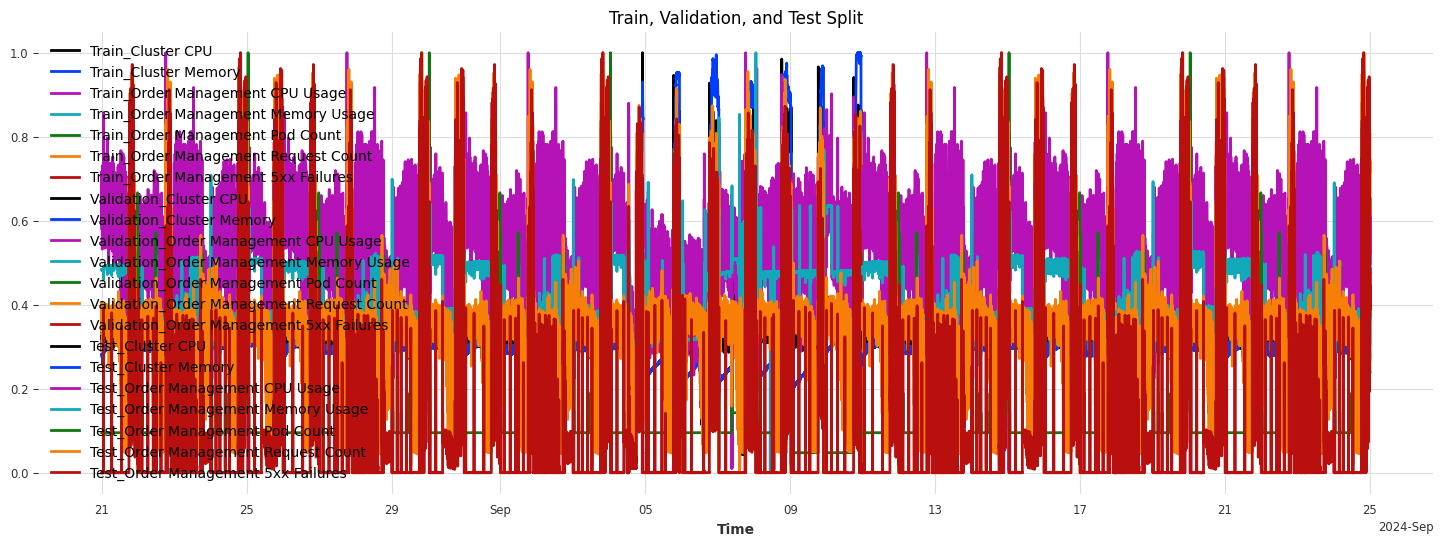

In [59]:
plt.figure(figsize=(18, 6))
train_series.plot(label='Train')
val_series.plot(label='Validation')
test_series.plot(label='Test')
plt.title("Train, Validation, and Test Split")
plt.legend()
plt.show()

In [60]:
multivariate_train_series = [train_series['Cluster CPU'], train_series['Cluster Memory'], train_series['Order Management CPU Usage'], train_series['Order Management Memory Usage'], train_series['Order Management Request Count'], train_series['Order Management 5xx Failures'], train_series['Order Management Pod Count']]
multivariate_val_series = [val_series['Cluster CPU'], val_series['Cluster Memory'], val_series['Order Management CPU Usage'], val_series['Order Management Memory Usage'], val_series['Order Management Request Count'], val_series['Order Management 5xx Failures'], val_series['Order Management Pod Count']]
multivariate_test_series = [test_series['Cluster CPU'], test_series['Cluster Memory'], test_series['Order Management CPU Usage'], test_series['Order Management Memory Usage'], test_series['Order Management Request Count'], test_series['Order Management 5xx Failures'], test_series['Order Management Pod Count']]


In [61]:
# Define NHITS model
order_nhits = NHiTSModel(
    model_name="order_nhits",
    input_chunk_length=1440,  # Past 24 hours time steps as input
    output_chunk_length=480,  # Predict the next 8 hours time steps
    n_epochs=30,            # Number of training epochs
    random_state=42,         # For reproducibility
    likelihood=GaussianLikelihood(),  # Likelihood model for probabilistic forecasts
    batch_size=64,
    lr_scheduler_cls=torch.optim.lr_scheduler.ExponentialLR,
    lr_scheduler_kwargs={"gamma": 0.999},
    save_checkpoints=True,
    force_reset=True,
    optimizer_kwargs={"lr": 1e-3},  # Define your learning rate here
)

# Define early stopping arguments
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 3,
    "mode": "min",
    "strict": True,
    "verbose": True,
}

# Set the log directory where logs will be saved
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)

# Create a TensorBoardLogger
logger = TensorBoardLogger(log_dir, name="microservices_all_models")

# Define your trainer arguments
pl_trainer_kwargs = {
    "max_epochs": 30,
    "logger": logger,
    "callbacks": [
        EarlyStopping(**early_stopping_args)
    ]
}

# Initialize your models dictionary
models = {
    "NHiTS_Order": order_nhits,
    # Add other models as needed
}

In [62]:
import os


# Define the directory where models will be saved
model_dir = os.path.expanduser("~/Documents/models/")
os.makedirs(model_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Train the models and load the model from its best state/checkpoint
for name, model in models.items():
    # Create a new Trainer for each model
    pl_trainer = pl.Trainer(**pl_trainer_kwargs)

    # Fit the model
    model.fit(
        series=multivariate_train_series,
        val_series=multivariate_val_series,
        verbose=True,
    )

    # Load the model from its best state/checkpoint
    models[name] = model.load_from_checkpoint(model_name=model.model_name, best=True)

    # Save the model
    model.save(os.path.join(model_dir, f"{name}.pt"))

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Predicting: |                                                                                                 …

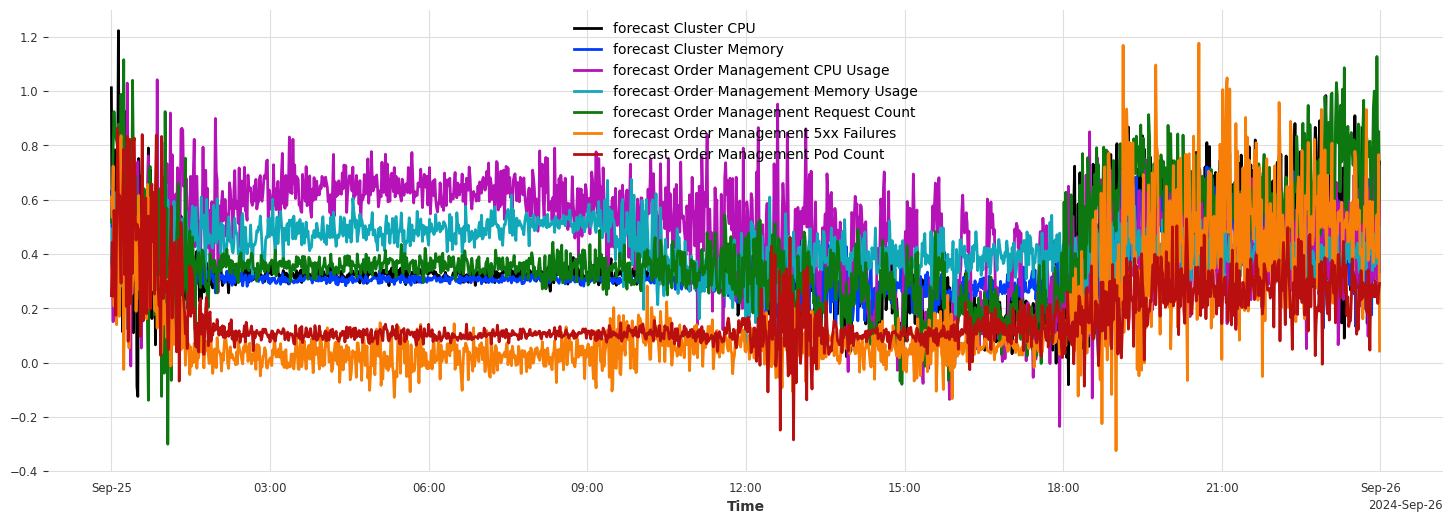

In [69]:
nhits_order_model = NHiTSModel.load(os.path.join(model_dir,'NHiTS_Order.pt'))
pred = nhits_order_model.predict(1440, series=multivariate_test_series)
plt.figure(figsize=(18, 6))
for series, label in zip(pred, ["Cluster CPU", "Cluster Memory", "Order Management CPU Usage", "Order Management Memory Usage", "Order Management Request Count", "Order Management 5xx Failures", "Order Management Pod Count"]):
    series.plot(label=f"forecast {label}")
plt.legend()

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

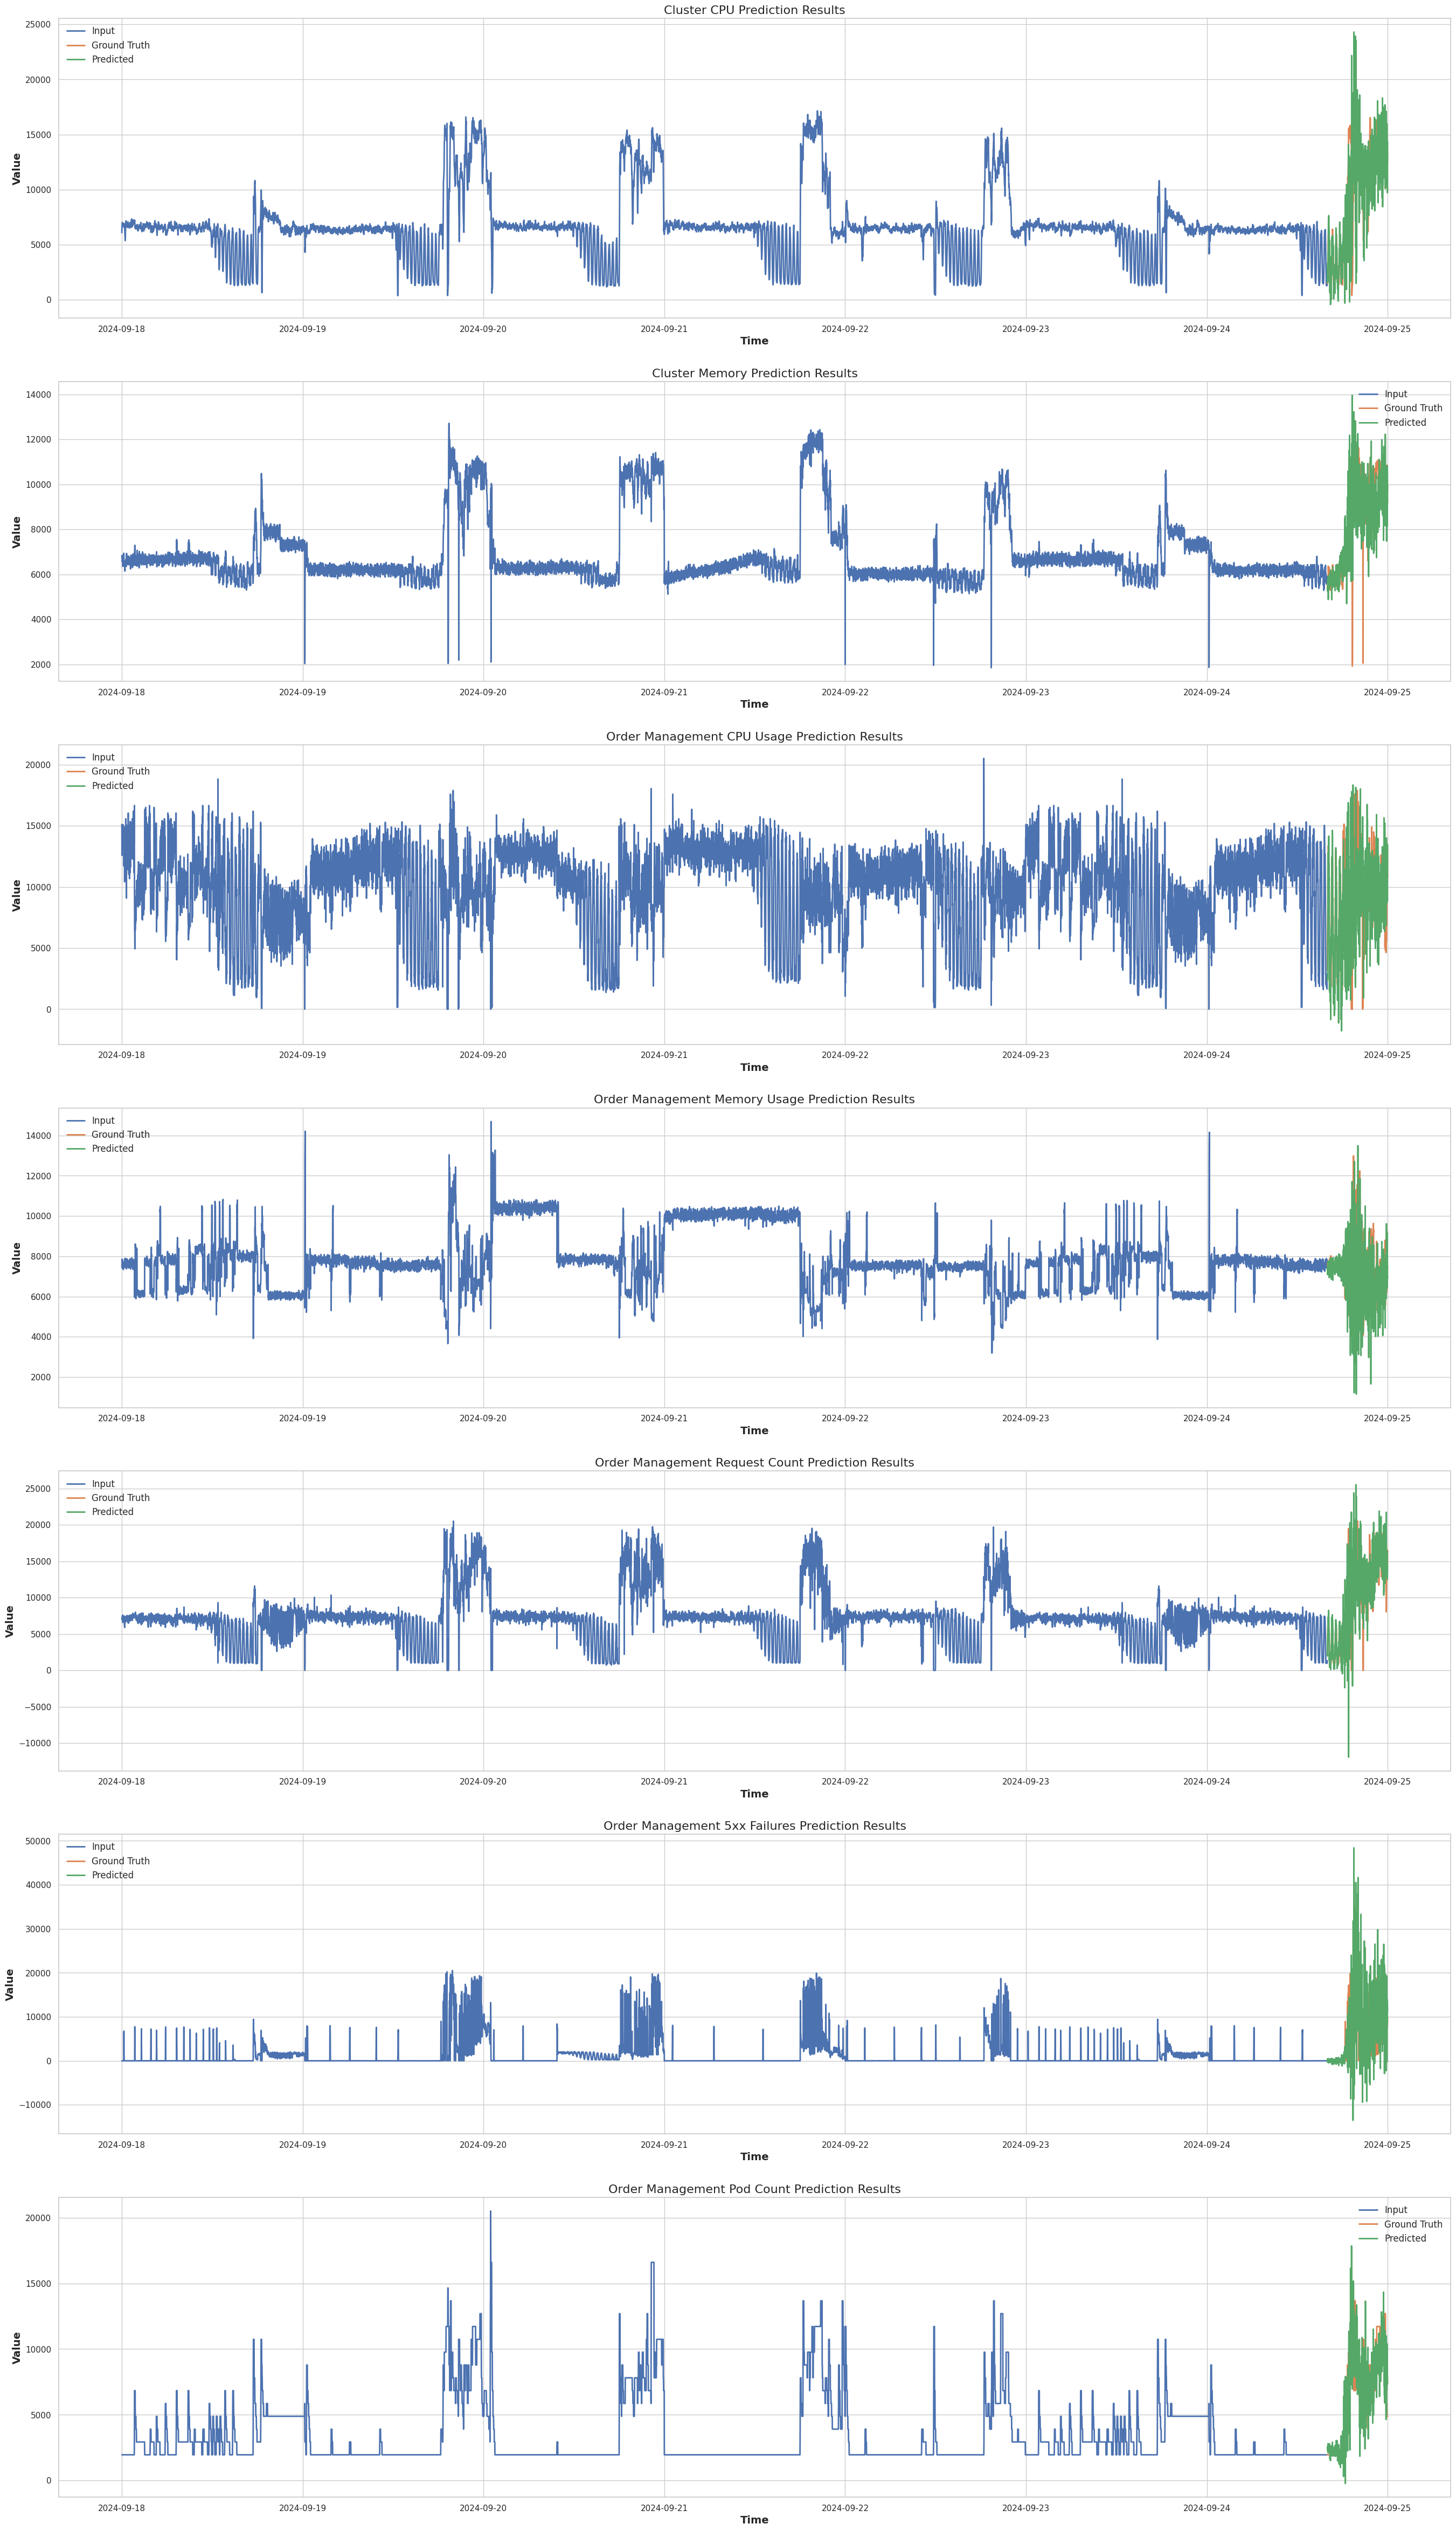

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

# Number of steps to predict
pred_steps = 480

# Define the names of the series for labeling and clarity
service_names = [
    'Cluster CPU', 
    'Cluster Memory', 
    'Order Management CPU Usage', 
    'Order Management Memory Usage', 
    'Order Management Request Count', 
    'Order Management 5xx Failures', 
    'Order Management Pod Count'
]

start_date = '2024-08-28'

# Create subplots (7 vertical subplots)
fig, axs = plt.subplots(7, 1, figsize=(28, 48))
fig.tight_layout(pad=5.0)

# Iterate over each series and plot
for i, (train_series, test_series) in enumerate(zip(multivariate_train_series, multivariate_test_series)):
    
    # Prepare the input and ground truth series
    pred_input = test_series[:-pred_steps]  # The input data for prediction
    ground_truth = test_series[-pred_steps:]  # The actual future data to compare against

    # Predict the next `pred_steps` points using the trained model
    pred_series = nhits_order_model.predict(n=pred_steps, series=pred_input)

    # Inverse transform the series to get actual values
    input_series = scaler.inverse_transform(pred_input).pd_dataframe()
    ground_series = scaler.inverse_transform(ground_truth).pd_dataframe()
    predicted_series = scaler.inverse_transform(pred_series).pd_dataframe()

    # Plot Input series (the data used for prediction)
    sns.lineplot(x=input_series.index, y=input_series.values.flatten(), ax=axs[i], label="Input", linewidth=2)

    # Plot Ground Truth (the actual data)
    sns.lineplot(x=ground_series.index, y=ground_series.values.flatten(), ax=axs[i], label="Ground Truth", linewidth=2)

    # Plot Predicted series (the model's prediction)
    sns.lineplot(x=predicted_series.index, y=predicted_series.values.flatten(), ax=axs[i], label="Predicted", linewidth=2)

    # Set title, labels, and legend for each subplot
    axs[i].set_title(f"{service_names[i]} Prediction Results", fontsize=16)
    axs[i].set_xlabel("Time", fontsize=14)
    axs[i].set_ylabel("Value", fontsize=14)
    axs[i].legend(fontsize=12)

# Save the plot
plt.savefig("multivariate_microservices_prediction.png")

# Show the plot
plt.show()
